In [1]:
!pip install yfinance

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import yfinance as yf

In [3]:
# Set the start and end date
start = '2018-01-01'
end = '2023-08-20'

# Set the ticker
symbol = 'HINDUNILVR.NS'

# Download the OHLCV data
df = yf.download(symbol, start, end)

[*********************100%%**********************]  1 of 1 completed


In [4]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-08-11,2535.000000,2536.649902,2499.000000,2501.800049,2501.800049,1472199
2023-08-14,2501.800049,2540.000000,2488.100098,2533.100098,2533.100098,1060479
2023-08-16,2534.000000,2555.050049,2524.399902,2552.600098,2552.600098,1155882
2023-08-17,2552.600098,2560.649902,2533.000000,2543.250000,2543.250000,1532873
2023-08-18,2532.100098,2567.750000,2532.100098,2554.750000,2554.750000,1970819


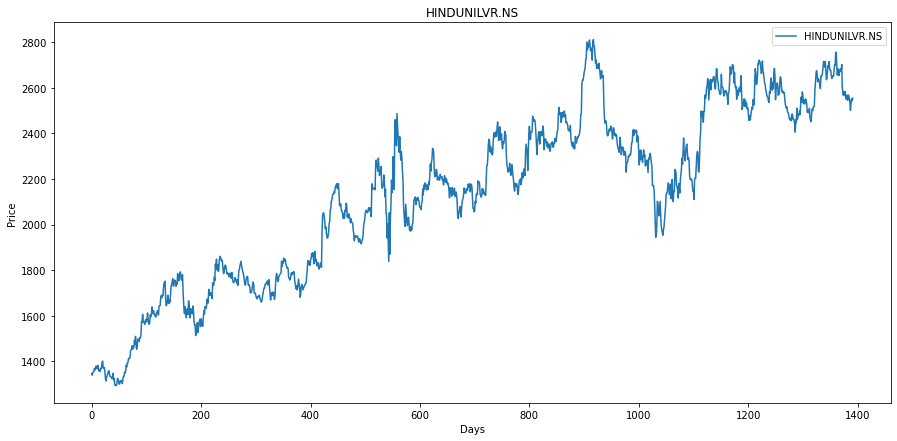

In [5]:
# Plot the close price data
series = df['Close']
series.index = np.arange(series.shape[0])

plt.figure(figsize=(15, 7))
plt.title(symbol)

plt.xlabel('Days')
plt.ylabel('Price')

plt.plot(series, label=symbol)

plt.legend()
plt.show()

In [6]:
series.shape

(1392,)

In [7]:
# Savitzky-Golay filter is used in signal processing to eliminate noise in a signal and improve the smoothness of a signal trend

from scipy.signal import savgol_filter

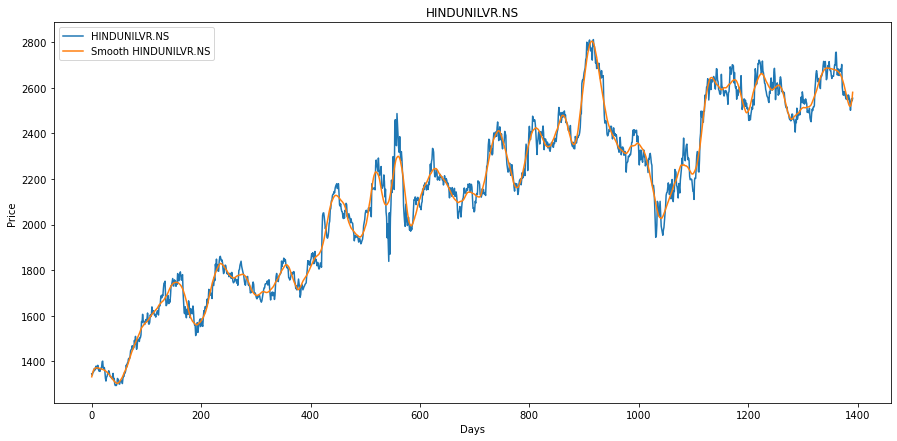

In [8]:
month_diff = series.shape[0] // 30

if month_diff == 0:
    month_diff = 1
    
    
# savgol_filter(data, window_length, polynomial_order_within_a_window)
# returns ndarray of smoothened data, same shape as input data

# small window size might not adequately capture significant changes in the data
# large window can overly smooth the data, blurring important features
# window length must be odd, to be centred at a data point
window = 2 * month_diff + 1

# Smooth price data
points = savgol_filter(series, window, 7)

plt.figure(figsize=(15, 7))
plt.title(symbol)

plt.xlabel('Days')
plt.ylabel('Price')

# close price data
plt.plot(series, label=symbol)

# smooth close price data
plt.plot(points, label=f'Smooth {symbol}')

plt.legend()
plt.show()

In [9]:
# function to calculate the distance between two points
def distance(pt1, pt2):
    a_sq = (pt2[0] - pt1[0]) ** 2
    b_sq = (pt2[1] - pt1[1]) ** 2
    
    return sqrt(a_sq + b_sq)

In [10]:
# function to calculate local minima and maxima points

def loc_min_max(points):
    loc_minima = []
    loc_maxima = []
    prev_pts = [(0, points[0]), (1, points[1])]
    for i in range(1, len(points) - 1):
        append_to = ''
        if points[i - 1] > points[i] < points[i + 1]:
            append_to = 'min'
        elif points[i - 1] < points[i] > points[i + 1]:
            append_to = 'max'
        
        if append_to:
            if len(loc_minima) or len(loc_maxima):
                   # we may have many local minima/maxima
                   # to avoid this, we only select a point as local minima/maxima
                   # if the distance between the current point and the next point is greater than 
                   # half the distance between the current and previous points
                   
                   prev_dist = distance(prev_pts[0], prev_pts[1])
                   curr_dist = distance(prev_pts[1], (i, points[i]))
                   
                   if curr_dist >= prev_dist * 0.4:
                       prev_pts = prev_pts[1], (i, points[i])
                       if append_to == 'min':
                           loc_minima.append((i, points[i]))
                       else:
                           loc_maxima.append((i, points[i]))
            else:
                   prev_pts = prev_pts[1], (i, points[i])
                   if append_to == 'min':
                       loc_minima.append((i, points[i]))
                   else:
                       loc_maxima.append((i, points[i]))
                   
    return np.array(loc_minima), np.array(loc_maxima)

In [11]:
loc_minima, loc_maxima = loc_min_max(points)

print(loc_minima.shape)
print(loc_maxima.shape)

(15, 2)
(16, 2)


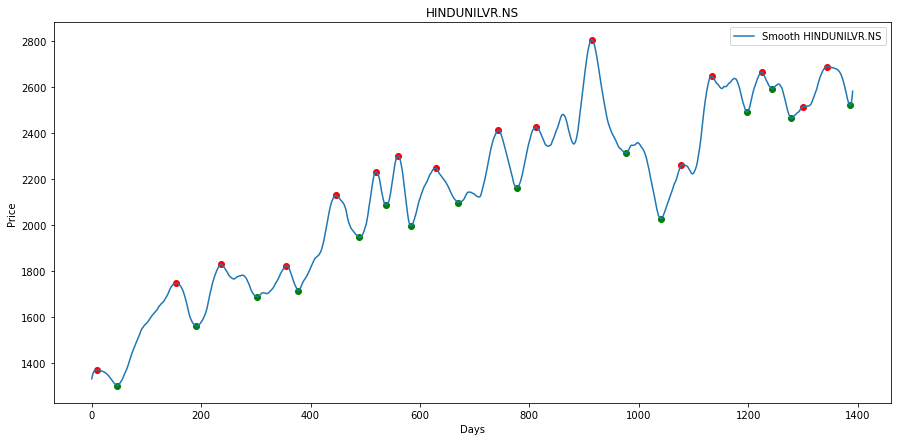

In [12]:
plt.figure(figsize=(15, 7))
plt.title(symbol)

plt.xlabel('Days')
plt.ylabel('Price')

# smooth close price data
plt.plot(points, label=f'Smooth {symbol}')

plt.scatter(loc_minima[:,0], loc_minima[:,1], c = 'g')
plt.scatter(loc_maxima[:,0], loc_maxima[:,1], c = 'r')

plt.legend()
plt.show()

In [13]:
# The line_mse() function computes and returns the mse for
# the distance of all points from the line passing throught
# points pt1 and pt2

norm = np.linalg.norm

def line_mse(pt1, pt2, data):
    sum_dist_sq = 0
    p1 = data[pt1]
    p2 = data[pt2]
    
    for p3 in data:
        # perpendicular distance of p3 from the line through p1 and p2
        # dist = |p1 - p3| . sin(theta)    where theta is the angle between p1-p3 and p2-p1
        dist = np.abs(np.cross(p1 - p2, p1 - p3)) / norm(p2 - p1)
        
        sum_dist_sq += dist ** 2
        
    return sum_dist_sq / len(data)

In [14]:
# A potential support line would be a line that connects two or more swing lows (local minima points)
# A potential resistance line would be any line that connects two or more swing highs (local maxima points)

# the s_r_lines() function identifies and returns all potential support
# and resistance line coordinates along with the corresponding mse values

def s_r_lines(data):
    lines = []
    for pt1 in range(len(data) - 1):
        for pt2 in range(len(data)):
            if pt1 != pt2:
                mse = line_mse(pt1, pt2, data)
                lines.append((data[pt1], data[pt2], mse))
                
    return lines

In [15]:
support_lines = s_r_lines(loc_minima)
resistance_lines = s_r_lines(loc_maxima)

In [16]:
def least_mse_line(data):
    best_line = data[0]
    least_mse = data[0][2]
    
    for line in data:
        if line[2] < least_mse:
            least_mse = line[2]
            best_line = line
            
    return best_line

In [17]:
support = least_mse_line(support_lines)
resistance = least_mse_line(resistance_lines)

In [18]:
# Assign the x and y co-ordinates

# For the support line
s_x1 = support[0][0]
s_x2 = support[1][0]
s_y1 = support[0][1]
s_y2 = support[1][1]

# For the resistance line
r_x1 = resistance[0][0]
r_x2 = resistance[1][0]
r_y1 = resistance[0][1]
r_y2 = resistance[1][1]

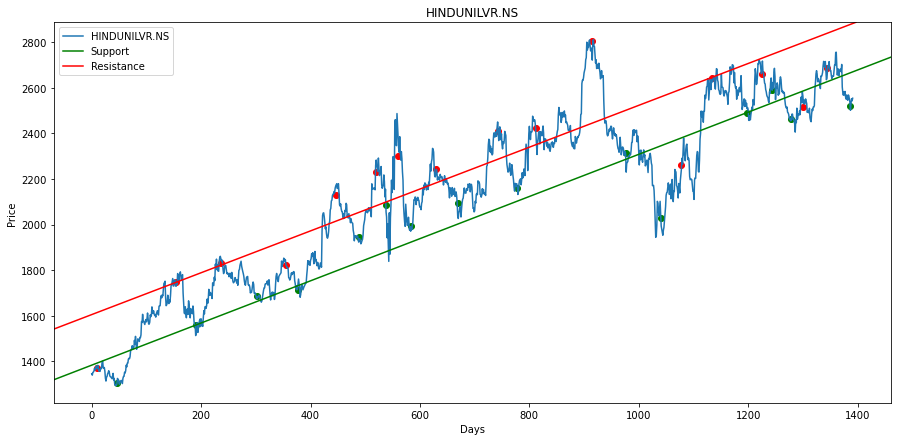

In [19]:
plt.figure(figsize=(15, 7))
plt.title(symbol)

plt.xlabel('Days')
plt.ylabel('Price')

# close price data
plt.plot(series, label=symbol)

# local minima and maxima points
plt.scatter(loc_minima[:,0], loc_minima[:,1], c = 'g')
plt.scatter(loc_maxima[:,0], loc_maxima[:,1], c = 'r')

# Support line
plt.axline((s_x1,s_y1), (s_x2,s_y2), label='Support', c='g')

# Resistance line
plt.axline((r_x1,r_y1), (r_x2,r_y2), label='Resistance', c='r')

plt.legend()
plt.show()